# Training Pipeline for Extended genQC with Stabilizer Circuits

This notebook demonstrates how to train an extended diffusion model in genQC to generate quantum circuits with more qubits by leveraging a stabilizer circuit dataset.

In [1]:
# Install genQC in editable mode if running locally
# !pip install -e ../genQC

import os
import time
import sys
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
from dataclasses import asdict

from qiskit.circuit.library import get_standard_gate_name_mapping

sys.path.append(".")

import my_genQC

# genQC related imports
from my_genQC.pipeline.multimodal_diffusion_pipeline import MultimodalDiffusionPipeline_ParametrizedCompilation
from my_genQC.utils.misc_utils import infer_torch_device, set_seed
from my_genQC.platform.circuits_generation import generate_circuit_dataset, CircuitConditionType  
from my_genQC.platform.simulation import Simulator, CircuitBackendType  
from my_genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer  
from my_genQC.pipeline.diffusion_pipeline import DiffusionPipeline  
from my_genQC.pipeline.compilation_diffusion_pipeline import DiffusionPipeline_Compilation  
from my_genQC.scheduler.scheduler import Scheduler  
from my_genQC.scheduler.scheduler_ddim import DDIMScheduler
from my_genQC.models.config_model import ConfigModel
from my_genQC.models.unet_qc import QC_Cond_UNet, QC_Compilation_UNet
from my_genQC.dataset.mixed_cached_dataset import MixedCachedOpenCLIPDataset  
from my_genQC.platform.simulation import Simulator
from my_genQC.models.frozen_open_clip import CachedFrozenOpenCLIPEmbedderConfig
from my_genQC.utils.misc_utils import DataLoaders
from my_genQC.models.unitary_encoder import Unitary_encoder_config

import my_genQC.dataset.circuits_dataset as circuits_dataset

device = infer_torch_device()
print(f'Using device: {device}')

Using device: cpu


## Dataset generation

In [2]:
string_to_gate_map = get_standard_gate_name_mapping()

dataset_config = {
    "MIN_GATES": 2,
    "MAX_GATES": 16,
    "AVAILABLE_GATES": ['h', 'cx', 'cz', 's', 'x', 'y', 'z'],  # clifford gates
    "NUM_QUBITS": 3,
    "NUM_SAMPLES": 512,
}

vocabulary = {gate: idx for gate, idx in zip(dataset_config["AVAILABLE_GATES"], range(len(dataset_config["AVAILABLE_GATES"])))}

In [3]:
# Setup  
simulator = Simulator(CircuitBackendType.QISKIT)  
tokenizer = CircuitTokenizer(vocabulary)  
  
# Generate dataset with custom gate set  
tensors, ys, Us, params = generate_circuit_dataset(  
    backend=simulator.backend,   
    tokenizer=tokenizer,  
    condition=CircuitConditionType.SRV,  
    total_samples=dataset_config["NUM_SAMPLES"],  
    num_of_qubits=dataset_config["NUM_QUBITS"],   
    min_gates=dataset_config["MIN_GATES"],   
    max_gates=dataset_config["MAX_GATES"],  
    min_sub_gate_pool_cnt=2,  # Minimum gates in pool  
    fixed_sub_gate_pool=dataset_config["AVAILABLE_GATES"]  # Your custom gate set  
)

[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...


NotImplementedError: Not implemented condition=<CircuitConditionType.SRV: 1>

In [4]:
print("Circuit:")
print(tensors[0])
print("Condition:")
print(ys[0])
print("Unitary:")
print(Us[0])
print("Parameters:")
print(params[0])

Circuit:
tensor([[-3, -2,  1,  4,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0],
        [ 3,  2,  0,  0,  0,  0,  3, -2,  3,  7, -3,  0,  0,  0, -2,  0],
        [ 0,  0,  0,  0,  1,  7, -3,  2, -3,  0,  0,  0,  5,  6,  2,  0]], dtype=torch.int32)
Condition:
Compile using: ['h', 'cx', 'cz', 's', 'x', 'y', 'z']
Unitary:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[

## Training

### Configurations

In [72]:
time_stamp = time.strftime('%m/%d/%y %H:%M:%S', time.localtime())

text_encoder_config = {
     'target': 'genQC.training.frozen_open_clip.CachedFrozenOpenCLIPEmbedder',
     'save_path': None,
     'save_datetime': time_stamp,
     'save_type': None,
     'params': {"arch":'ViT-B-32', "version":'laion2b_s34b_b79k', "max_length":77, "freeze":True, "layer":'penultimate', "enable_cache_token_limit":True}
}

model_config = {
    'target': 'genQC.models.unet_qc.QC_Compilation_UNet',
    'save_path': None,
    'save_datetime': time_stamp,
    'save_type': 'pt',
    'params': {"model_features":[128, 128, 256], "clr_dim":8, "num_clrs":len(tokenizer.vocabulary) + 1 + 1, "t_emb_size":256, "cond_emb_size":512, "num_heads":[8, 8, 2], "num_res_blocks":[2, 2, 4], "transformer_depths":[1, 2, 1],
              "unitary_encoder_config":Unitary_encoder_config(cond_emb_size=512, model_features=[2, 32, 64, 512], num_heads=8, transformer_depths=[2, 2], dropout=0.2)}
}

embedder_config = {
    'target': 'genQC.models.unet_qc.QC_Compilation_UNet',
    'save_path': None,
    'save_datetime': time_stamp,
    'save_type': 'pt',
    'params': {"model_features":[128, 128, 256], "clr_dim":8, "num_clrs":len(tokenizer.vocabulary) + 1 + 1, "t_emb_size":256, "cond_emb_size":512, "num_heads":[8, 8, 2], "num_res_blocks":[2, 2, 4], "transformer_depths":[1, 2, 1],
              "unitary_encoder_config":Unitary_encoder_config(cond_emb_size=512, model_features=[2, 32, 64, 512], num_heads=8, transformer_depths=[2, 2], dropout=0.2)}
} 

scheduler_config = {Ple
    'target': 'genQC.scheduler.scheduler_ddim.DDIMScheduler',
    'params': {'device': device, 'num_train_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02, 'beta_schedule': 'cos_alpha', 'input_perturbation': 0.1, 'prediction_type': 'epsilon', 'eta': 1
}}

# meta-data of dataset
paras = {}
paras["store_dict"]     = {'x':'tensor', 'y':'numpy', 'U': 'tensor'}   #what is in the datset, with type
paras["optimized"]      = True    
paras["dataset_to_gpu"] = True if device=="cuda" else False
paras["random_samples"] = dataset_config["NUM_SAMPLES"]
paras["num_of_qubits"]  = dataset_config["NUM_QUBITS"]
paras["min_gates"]      = dataset_config["MIN_GATES"]
paras["max_gates"]      = dataset_config["MAX_GATES"]
paras["gate_pool"]      = dataset_config["AVAILABLE_GATES"]
paras["max_params"]     = 0
paras["pad_constant"]   = len(vocabulary) + 1

In [73]:
# Step 2: Create dataset object  
text_encoder = ConfigModel.from_config(text_encoder_config, device)  # Text encoder config  
my_dataset = circuits_dataset.CircuitsConfigDataset(device=device, **paras)  
my_dataset.x = tensors  
my_dataset.y = ys  
my_dataset.U = Us.float()

datasets_list = [my_dataset]

parameters = asdict(my_dataset.params_config)
parameters["model_scale_factor"] = 4
mixed_dataset, mixed_dataset_test = circuits_dataset.MixedCircuitsConfigDataset.from_datasets(datasets_list,
                                                                          balance_maxes=[int(1e8)],          # what the maximum prompt (y) balance limit is, can be used to balance SRVs for different qubit numbers                                      
                                                                          pad_constant=paras["pad_constant"],
                                                                          device=device, 
                                                                          bucket_batch_size=-1,         # if we use bucket padding
                                                                          max_samples=[int(1e8)],
                                                                          **parameters)

# Create DataLoaders 
dataloaders = mixed_dataset.get_dataloaders(batch_size=32, p_valid=0.1, text_encoder=text_encoder)
model = QC_Compilation_UNet.from_config(model_config, device, freeze=False)  # Your model configuration  
embedder = QC_Compilation_UNet.from_config(embedder_config, device)  # Embedder config  
scheduler = DDIMScheduler.from_config(scheduler_config, device)

[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given `config` on cpu.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Found no key `save_type` in `config`. No state dict loaded.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Freeze model: True


  0%|          | 0/1 [00:00<?, ?it/s]

 - balance_tensor_dataset, njobs=1, number of samples=507
 - uniquify_tensor_dataset, number of samples now 507
 - balancing


  0%|          | 0/1 [00:00<?, ?it/s]

 - dataset size after balancing 507
[INFO]: allocate memory for U (507, 2, 8, 8) on cpu approx. 0.000 GB
Split: Train 482 - Test 25 

[DEBUG]: run get_dataloaders.x_y_preprocess
[INFO]: Not balancing dataset!  balance_max=None
[INFO]: Generate cache: converting tensors to str and tokenize
 - to str list
 - tokenize_and_push_to_device
 - generate_cache
[INFO]: - `generate_cache` infered a TOKEN limit of 28


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]: caching trying to allocate memory (2, 77, 512) on cpu, approx. 0.000 GB
[INFO]: Generated cache, y_ptrs.shape=torch.Size([482])
[DEBUG]: run get_dataloaders.valid_split
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given `config` on cpu.
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet`. No `save_path` provided. Found no key `save_path` in `config`. No state dict loaded.
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet`. Freeze model: False
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given `config` on cpu.
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet`. No `save_path` provided. Found no key `save_path` in `config`. No state dict loaded.
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet`. Freeze model: True


Fit:   0%|          | 0/5 [00:00<?, ? epoch/s]

Epoch 0:   0%|          | 0/14 [00:00<?, ? batch/s]

Epoch 0:   0%|          | 0/2 [00:00<?, ? batch/s]

Epoch 1:   0%|          | 0/14 [00:00<?, ? batch/s]

Epoch 1:   0%|          | 0/2 [00:00<?, ? batch/s]

Epoch 2:   0%|          | 0/14 [00:00<?, ? batch/s]

Epoch 2:   0%|          | 0/2 [00:00<?, ? batch/s]

Epoch 3:   0%|          | 0/14 [00:00<?, ? batch/s]

Epoch 3:   0%|          | 0/2 [00:00<?, ? batch/s]

Epoch 4:   0%|          | 0/14 [00:00<?, ? batch/s]

Epoch 4:   0%|          | 0/2 [00:00<?, ? batch/s]

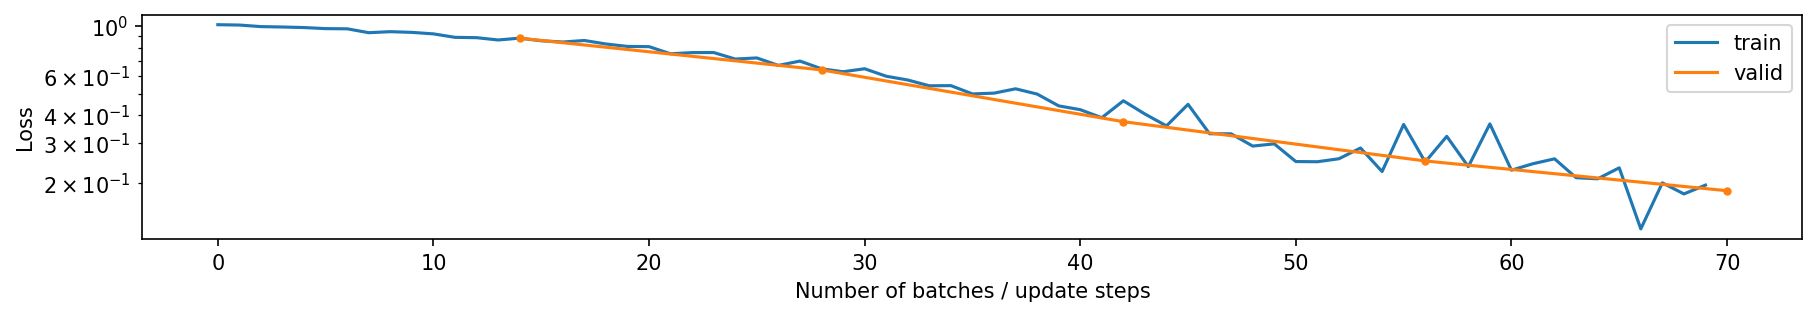

In [74]:
# alternative:
# pipeline = DiffusionPipeline.from_config_file() where all conf from above are in that file

training_config = {
    "LR": 1e-4,
    "OPTIMIZER": torch.optim.Adam,  
    "LOSS": torch.nn.MSELoss,  
    "NUM_EPOCHS": 5,
} 

pipeline = DiffusionPipeline_Compilation(  
    scheduler=scheduler,  
    model=model,  
    text_encoder=text_encoder,  
    embedder=embedder,  
    device=device,  
    enable_guidance_train=True,  
    guidance_train_p=0.1,  
    cached_text_enc=True  
)  

# Step 5: Compile pipeline for training  
pipeline.compile(  
    optim_fn=training_config["OPTIMIZER"],  
    loss_fn=training_config["LOSS"],  
    lr=training_config["LR"] 
) 

pipeline.fit(  
    num_epochs=training_config["NUM_EPOCHS"],  
    data_loaders=dataloaders  
)  